In [1]:
import os, gc, psutil

import math
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
tf.version.VERSION

'2.2.0'

In [3]:
p = psutil.Process(os.getpid())
cur_memory_usage = p.memory_info().rss / 1024 / 1024
print(cur_memory_usage)

281.828125


In [4]:
model = Sequential()
model.add(Dense(5, input_dim=10, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(5, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [5]:
# plot the result
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5)                 55        
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 30        
Total params: 115
Trainable params: 115
Non-trainable params: 0
_________________________________________________________________
None


In [6]:
# save the model using TensorFlow SavedModel format
tf.saved_model.save(model, 'saved_model')

W0619 15:52:03.966113 4540169664 deprecation.py:506] From /Users/mkarthik/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [7]:
# demonstrate memory leak by repeated reloading
num_iters = 1000
memory_usage = [0 for j in range(num_iters)]
for i in range(num_iters):
    # adding clear session doesn't stop the problem
    # and not really sure why we need this in TF 2.x?
    keras.backend.clear_session()

    # load the model
    net = tf.saved_model.load('saved_model')
    
    # ensure that garbage collector runs
    gc.collect()

    # get resident set size, memory usage, for current process
    p = psutil.Process(os.getpid())
    cur_memory_usage = p.memory_info().rss / 1024 / 1024
    # print(cur_memory_usage)
    memory_usage[i] = cur_memory_usage
    

Text(0, 0.5, 'Resident Set Size (MB)')

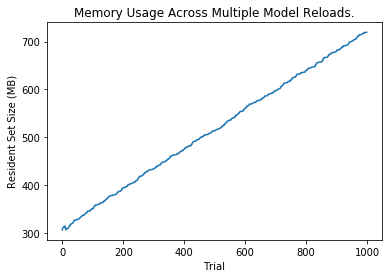

In [8]:
plt.plot(memory_usage)
plt.title('Memory Usage Across Multiple Model Reloads.')
plt.xlabel('Trial')
plt.ylabel('Resident Set Size (MB)')

In [9]:
print("Memory leak (MB) per trial = ", (memory_usage[-1]-memory_usage[0])/1000)

Memory leak (MB) per trial =  0.4126875
